In [36]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os, requests
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord
from style import output_folder, big_fontsize, base_width, base_height, dpi, small_fontsize
import seaborn as sns
import json
from astropy.time import Time
import astropy.units as u

In [80]:
alerts = pd.read_csv('data/ASASSN_sample_paper_IceCube_info.csv', index_col=0)

def floatify(x):
    if isinstance(x, str):
        return [float(s) for s in x.replace('[', '').replace(']', '').split(',')]
    
for col in ["RA Unc (rectangle)", "Dec Unc (rectangle)"]:
    alerts[col + ' float'] = alerts[col].apply(floatify)
alerts

,Event,Class,RA,RA Unc (rectangle),Dec,Dec Unc (rectangle),arrival time [UT],initial RA,initial Dec,initial Error90 [arcmin],retracted,RA Unc (rectangle) float,Dec Unc (rectangle) float
23,IC160427A,HESE,240.57,"[0.6, -0.6]",9.34,"[0.6, -0.6]",2016-04-27 05:52:32.00,239.6639,6.8528,534.00,False,"[0.6, -0.6]","[0.6, -0.6]"
24,IC160731A,EHE,214.50,"[0.75, -0.75]",-0.33,"[0.75, -0.75]",2016-07-31 01:55:04.00,214.5440,-0.3347,20.99,False,"[0.75, -0.75]","[0.75, -0.75]"
24,IC160731A,HESE,214.50,"[0.75, -0.75]",-0.33,"[0.75, -0.75]",2016-07-31 01:55:04.00,215.1090,-0.4581,73.79,False,"[0.75, -0.75]","[0.75, -0.75]"
25,IC160806A,EHE,122.81,"[0.5, 0.5]",-0.81,"[0.5, -0.5]",2016-08-06 12:21:33.00,122.7980,-0.7331,6.67,False,"[0.5, 0.5]","[0.5, -0.5]"
26,IC160814A,HESE,200.30,"[2.43, -3.03]",-32.40,"[1.39, -1.21]",2016-08-14 21:45:54.00,199.3100,-32.0165,89.39,False,"[2.43, -3.03]","[1.39, -1.21]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,IC210608A,BRONZE,337.41,"[4.89, -11.64]",18.37,"[3.75, -3.24]",2021-06-08 03:41:00.97,337.0182,18.6470,78.35,False,"[4.89, -11.64]","[3.75, -3.24]"
21,IC210629A,BRONZE,340.75,"[1.11, -2.23]",12.94,"[0.91, -0.93]",2021-06-29 18:09:44.22,340.6350,12.6111,30.80,False,"[1.11, -2.23]","[0.91, -0.93]"
83,IC210717A,EXTRA,46.49,"[2.40, -2.57]",-1.34,"[2.63, -3.41]",NaN,NaN,NaN,NaN,False,"[2.4, -2.57]","[2.63, -3.41]"
84,IC210730A,BRONZE,105.73,"[2.00, -1.85]",14.79,"[0.91, -0.86]",2021-07-30 22:12:40.62,105.8360,14.8168,30.80,False,"[2.0, -1.85]","[0.91, -0.86]"


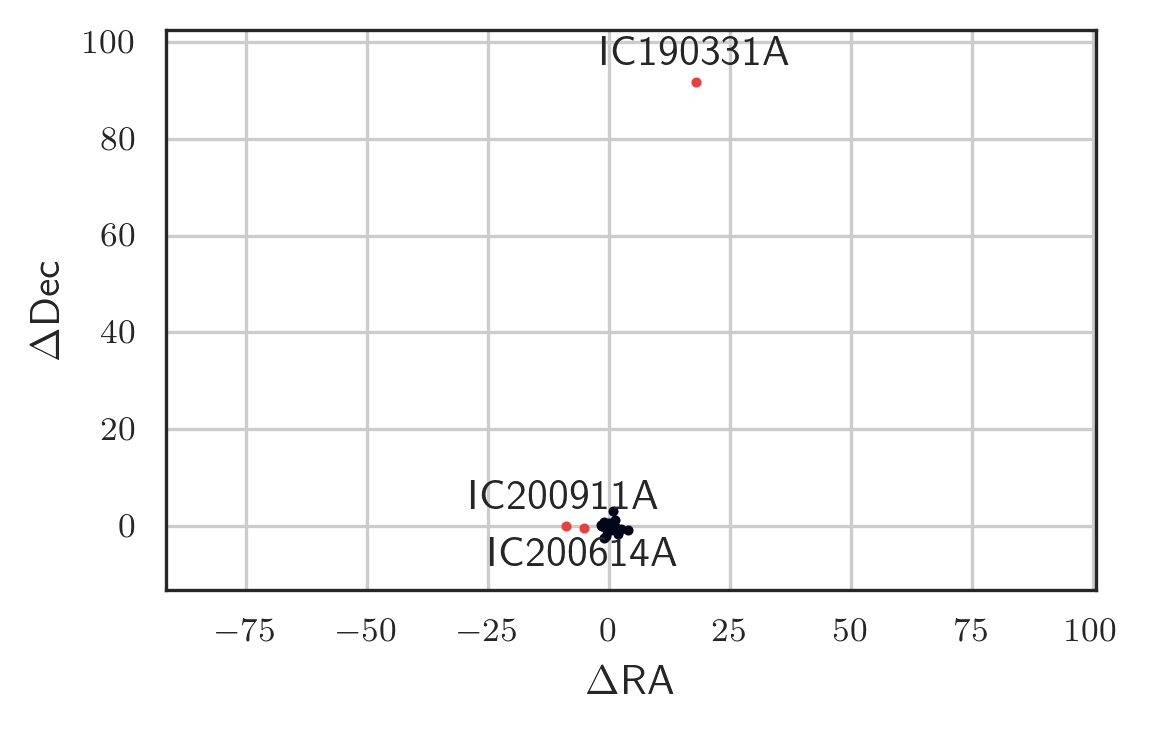

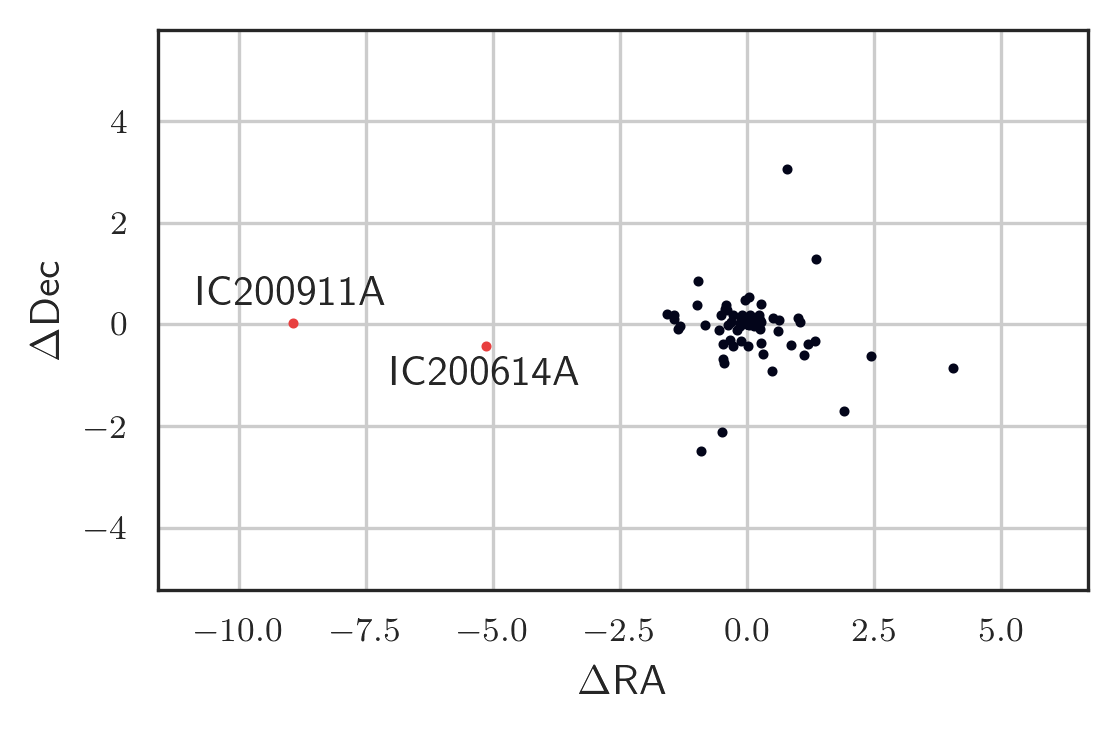

In [130]:
d_ra = alerts['initial RA'] - alerts['RA']
d_dec = alerts['initial Dec'] - alerts['Dec']

thresh = 5
r = np.sqrt(d_ra**2 + d_dec**2)
m = r >= thresh
rm = ~alerts.retracted

cmap = plt.get_cmap()

for cc in  ['', '_without_IC190331A']:
    
    if '_without' in cc:
        mm = alerts.Event == 'IC190331A'
        rm = rm & (~mm)

    fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)
    ax.scatter(d_ra[rm & (~m)], d_dec[rm & (~m)], s=2, color=cmap(0))
    ax.scatter(d_ra[rm & (m)], d_dec[rm & (m)], s=2, color=cmap(0.6))

    for i, r in alerts[m].iterrows():
        ii = -1 if r.Event == "IC200614A" else 1
        if '_without' in cc:
            ii *= 0.1
        ax.annotate(r.Event, (d_ra.loc[i], d_dec.loc[i]+5.7*ii), fontsize=big_fontsize, ha='center', va='center')
    
    xfact = 5 if '_without' not in cc else 2
    yfact = 6 if '_without' not in cc else 0
    
    ax.set_xlim(np.array(ax.get_xlim()) + xfact*np.sign(ax.get_xlim()))
    ax.set_ylim(np.array(ax.get_ylim()) + yfact*np.sign(ax.get_ylim()))
    ax.set_aspect(1, adjustable='datalim')
    ax.set_ylabel('$\Delta$Dec')
    ax.set_xlabel('$\Delta$RA')
    ax.grid()
    
    fig.savefig(os.path.join(output_folder, f"alerts_deviation_initial_final{cc}.pdf"))
    plt.show()
    plt.close()


IC190331A


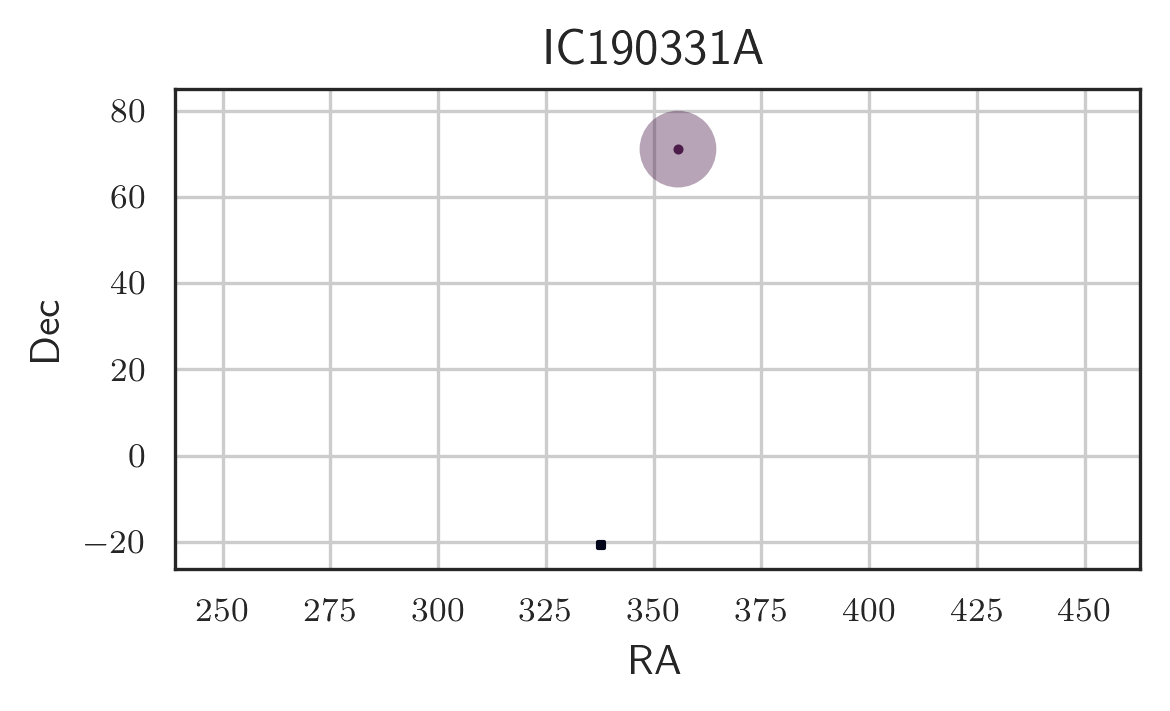

IC200614A


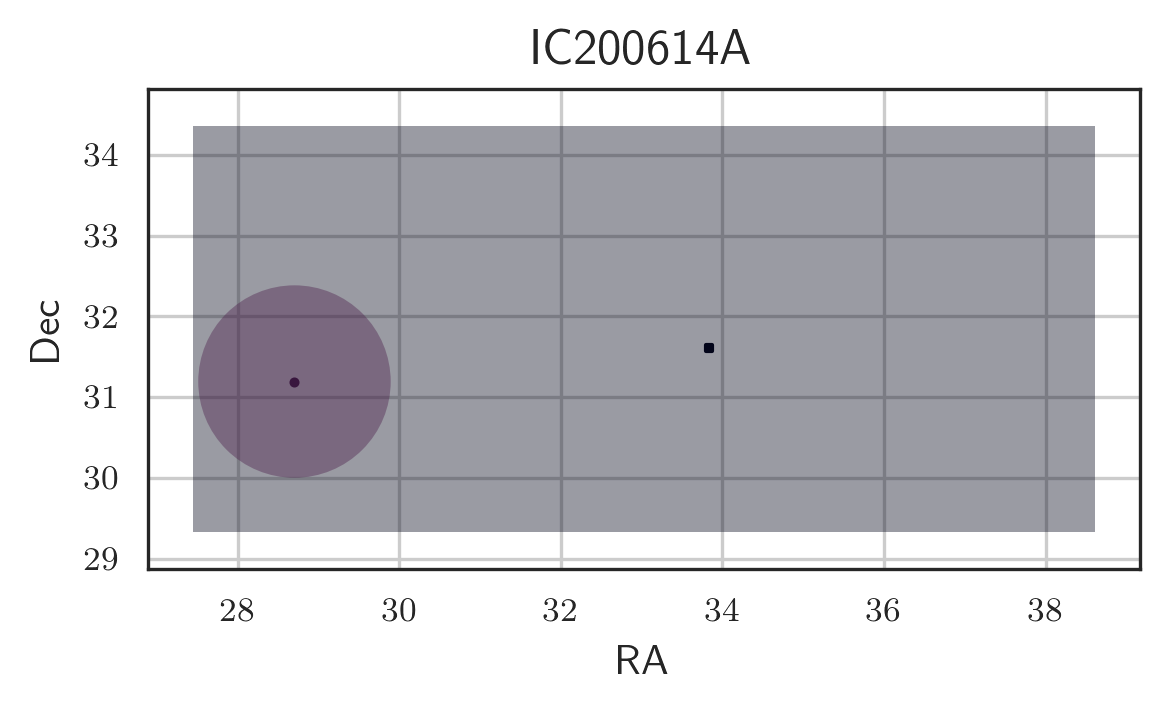

IC200911A


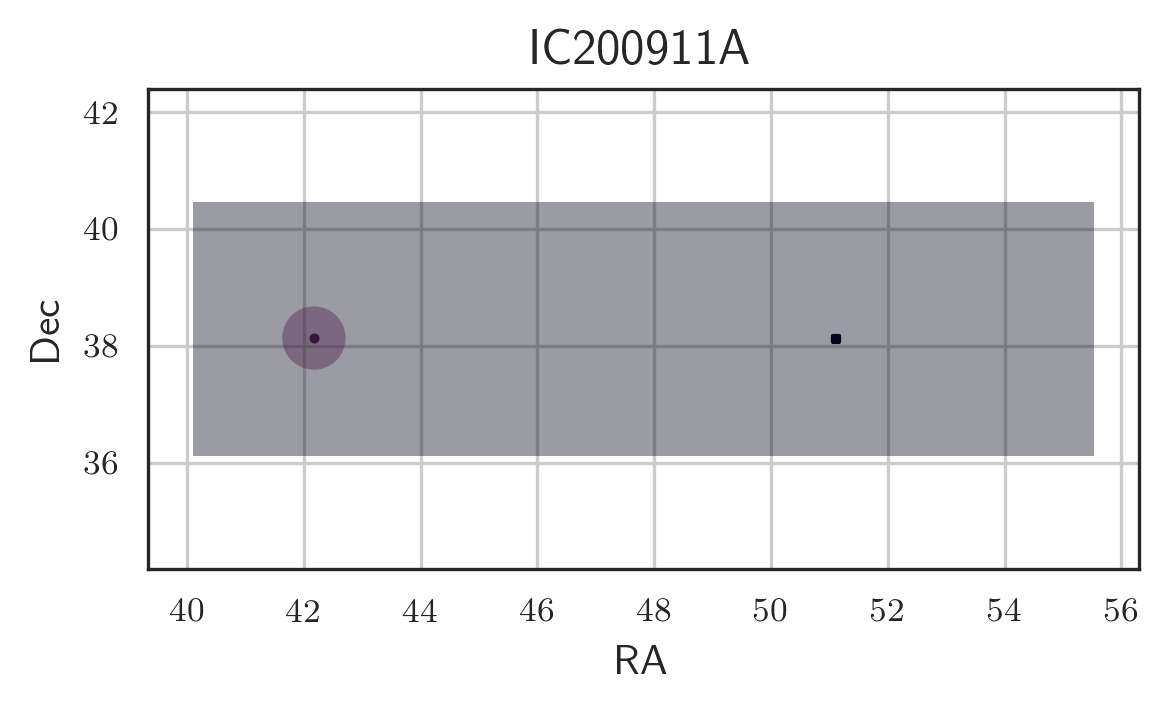

In [132]:
for i, r in alerts[m].iterrows():
    print(r.Event)
    fig, ax = plt.subplots(figsize=(base_width, base_height), dpi=dpi)
    
    ax.set_aspect(1, adjustable='datalim')
    ax.scatter(r['RA'], r['Dec'], color=cmap(0), marker='s', s=2)
    left_bottom_corner = (r['RA'] + r['RA Unc (rectangle) float'][1], r['Dec'] + r['Dec Unc (rectangle) float'][1])
    extent = (r['RA Unc (rectangle) float'][0] - r['RA Unc (rectangle) float'][1],
              r['Dec Unc (rectangle) float'][0] - r['Dec Unc (rectangle) float'][1])
    final_e = plt.Rectangle(left_bottom_corner, extent[0], extent[1], fc=cmap(0), alpha=0.4, ec=None, ls='')
    ax.add_patch(final_e)
    
    ax.scatter(r['initial RA'], r['initial Dec'], color=cmap(0.2), s=2)
    initial_e = r['initial Error90 [arcmin]'] * u.arcmin
    initial_contour = plt.Circle((r['initial RA'], r['initial Dec']), initial_e.to('deg').value, alpha=0.4, fc=cmap(0.2), ec=None, ls='')
    ax.add_patch(initial_contour)
    
    ax.set_title(r.Event)
    ax.grid()
    
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    
    fig.tight_layout()
    fig.savefig(os.path.join(output_folder, f"{r.Event}.pdf"))
    plt.show()
    plt.close()

In [95]:
alerts[alerts.Event == "IC190331A"]

,Event,Class,RA,RA Unc (rectangle),Dec,Dec Unc (rectangle),arrival time [UT],initial RA,initial Dec,initial Error90 [arcmin],retracted,RA Unc (rectangle) float,Dec Unc (rectangle) float
45,IC190331A,HESE,337.68,"[0.23, -0.34]",-20.7,"[0.3, -0.48]",2019-03-31 06:55:43.44,355.6349,71.117,534.0,False,"[0.23, -0.34]","[0.3, -0.48]"


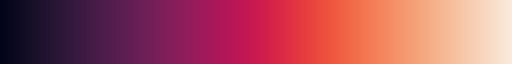

In [24]:
plt.get_cmap()